<ipython-input-3-14e8038fcd72>:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel("tfg.xlsx", parse_dates=["trimestres"])
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Columnas disponibles: ['españa', 'turismo_internacional', 'exportaciones', 'importaciones', 'tasa_actividad', 'ipi', 'deuda_publica']
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-355.675, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-353.614, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.187 seconds
===== Resumen del Modelo ARIMAX con exógenas diferenciadas =====
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   87
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 179.837
Date:                Wed, 12 Mar 2025   AIC                           -355.675
Time:                        15:09:25   BIC                           -350.766
Sample:                             0   HQIC                          -353.699
                                 - 87                                      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


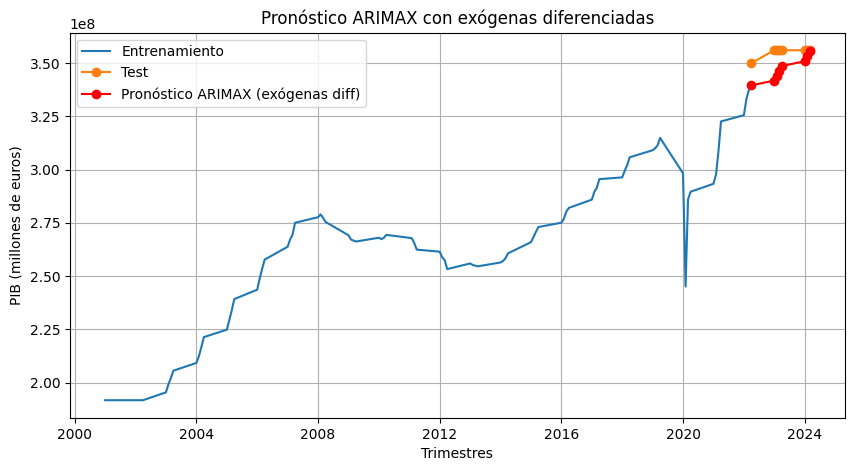

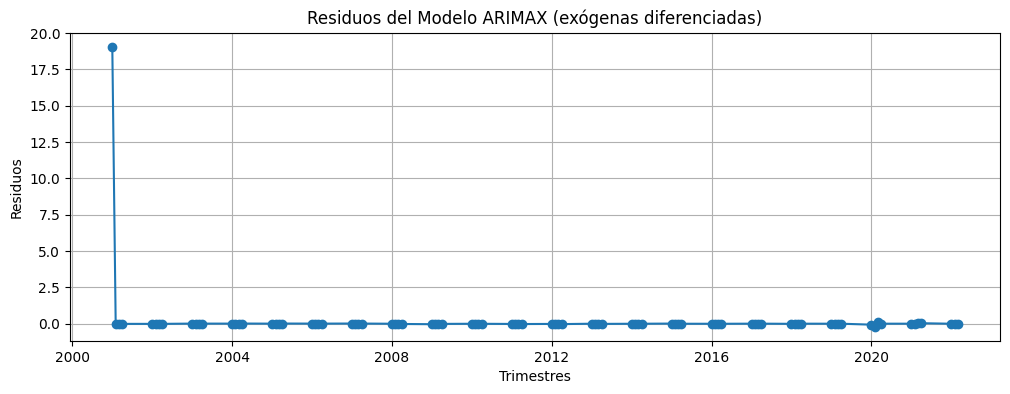

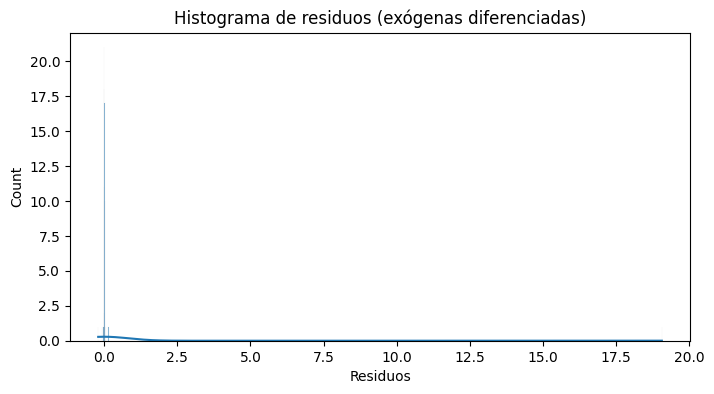

<Figure size 1000x400 with 0 Axes>

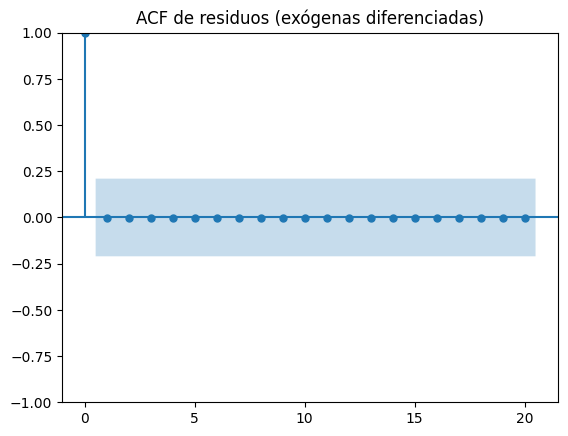

Resultado del Test de Ljung-Box para residuos (exógenas diferenciadas):
     lb_stat  lb_pvalue
10  0.000648        1.0
                Variable       VIF
0                  const  1.514351
1  turismo_seasonal_diff  1.205043
2     exportaciones_diff  2.326550
3     importaciones_diff  2.172379
4    tasa_actividad_diff  1.369951
5               ipi_diff  1.081416
6     deuda_publica_diff  1.096217


In [ ]:

# 1) Instalar e importar librerías

!pip install pmdarima --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape

# 2) Cargar y preparar los datos

df = pd.read_excel("tfg.xlsx", parse_dates=["trimestres"])
df.set_index("trimestres", inplace=True)
df.sort_index(inplace=True)

# Eliminar la variable "precio_petroleo" si está presente
if "precio_petroleo" in df.columns:
    df.drop("precio_petroleo", axis=1, inplace=True)

print("Columnas disponibles:", df.columns.tolist())


# 3) Ingeniería de variables
# Crear dummy para turismo: 0 antes de 2020-03-01, 1 a partir de esa fecha.
df["dummy_turismo"] = (df.index >= pd.Timestamp("2020-03-01")).astype(int)

# Para "turismo_internacional" aplicamos diferencia estacional (lag=4)
df["turismo_seasonal_diff"] = df["turismo_internacional"].diff(4)

# Para las demás variables exógenas, aplicamos diferencia simple
other_exog = ["exportaciones", "importaciones", "tasa_actividad", "ipi", "deuda_publica"]
for col in other_exog:
    df[f"{col}_diff"] = df[col].diff()

# Definir la lista final de variables exógenas diferenciadas:
# Se usa la diferencia estacional para turismo y la diferencia simple para el resto,
# y se añade la dummy (sin diferenciar).
exog_diff_vars = ["turismo_seasonal_diff"] + [f"{col}_diff" for col in other_exog] + ["dummy_turismo"]

# Eliminar las filas con nulos generadas por las diferencias
df.dropna(subset=exog_diff_vars, inplace=True)

Q1 = df["españa"].quantile(0.25)
Q3 = df["españa"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df["españa"] = df["españa"].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# 4) Transformar la variable objetivo a log

y = df["españa"]
y_log = np.log(y)

# 5) División en Entrenamiento y Test

n_test = 8  # Usamos los últimos 8 trimestres para validación
y_train_log = y_log.iloc[:-n_test]
y_test_log  = y_log.iloc[-n_test:]
y_test_original = y.iloc[-n_test:]

X_diff = df[exog_diff_vars]
X_train_diff = X_diff.iloc[:-n_test]
X_test_diff  = X_diff.iloc[-n_test:]


# 6) Ajuste del modelo ARIMAX con exógenas diferenciadas

model_arimax = pm.auto_arima(
    y_train_log,
    exogenous=X_train_diff,
    start_p=0, start_q=0,
    max_p=0, max_q=0,
    d=1,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)


print("" Resumen del Modelo ARIMAX con exógenas diferenciadas")
print(model_arimax.summary())

# ==========================================
# 7) Pronóstico y Evaluación
# ==========================================
n_periods = n_test
forecast_log = model_arimax.predict(n_periods=n_periods, exogenous=X_test_diff)
forecast_original = np.exp(forecast_log)

rmse, mae, mape = evaluate_forecast(y_test_original, forecast_original)
print(f"Errores en Test: RMSE={rmse:.3f}, MAE={mae:.3f}, MAPE={mape:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(y_train_log.index, np.exp(y_train_log), label="Entrenamiento")
plt.plot(y_test_original.index, y_test_original, label="Test", marker='o')
plt.plot(y_test_original.index, forecast_original, label="Pronóstico ARIMAX (exógenas diff)", marker='o', color='red')
plt.xlabel("Trimestres")
plt.ylabel("PIB (millones de euros)")
plt.title("Pronóstico ARIMAX con exógenas diferenciadas")
plt.legend()
plt.grid(True)
plt.show()


# 8) Diagnóstico de residuos

residuals = model_arimax.resid()

plt.figure(figsize=(12, 4))
plt.plot(residuals, marker='o')
plt.title("Residuos del Modelo ARIMAX (exógenas diferenciadas)")
plt.xlabel("Trimestres")
plt.ylabel("Residuos")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title("Histograma de residuos (exógenas diferenciadas)")
plt.xlabel("Residuos")
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=20)
plt.title("ACF de residuos (exógenas diferenciadas)")
plt.show()

lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Resultado del Test de Ljung-Box para residuos (exógenas diferenciadas):")
print(lb_test)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_vif = sm.add_constant(X_train_diff.drop(columns=["dummy_turismo"]))  # dummy_turismo es 0/1
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

